# Bootstrapping
In Chapter 3, we have learned that Bootstrapping is a powerful statistical tool that helps us to measure the uncertainty in the prediction of a model. In this activity, we implement this technique to assess variations in the prediction of KNN classifier.

# Steps for Activity 1.2
<ol>
	<li>Load the training dataset,</li>
    <li>Implement bootstrap sampling,</li>
	<li>Apply <code>bootstrap </code>function <code> with times = 40</code> (the number of samples) <code>and size = 50 </code> (the size of each sample) on <code>knn </code>for $K\in{1,\dots,30}$,</li>
	<li>Report the uncertainty in the prediction in percentages.</li>
	<li>Repeat Step 2 with different values of K, times and size.</li>
</ol>

# Implementation of the Above Steps

In [1]:
# load libraries:
library(reshape2)
library(ggplot2)

# Load data:
library(datasets)
data(iris)

# permute iris:
iris <- iris[sample(1:nrow(iris),nrow(iris)),]

# create training and testing datasets:
train.index = 1:100
train.data <- iris[train.index, -5]
train.label <- iris[train.index, 5]
test.data <- iris[-train.index, -5]
test.label <- iris[-train.index, 5]

In [2]:
# define a function that generates sample indixes based on bootstrap technique
# The bootstrap technique is sampling from the original with replacement

boot <- function (original.size=100, sample.size=original.size, times=100){
    indx <- matrix(nrow=times, ncol=sample.size) # create an empty matrix with number of times as rows and sample size as cols
    
    # for each row in the empty matrix, return a sample with replacement of size sample.size from 1 to original.size
    # in this example, it is sample 10 numbers from 1:100 with replacement a total of 5 times
    
    for (t in 1:times){
        indx[t, ] <- sample(x=original.size, size=sample.size, replace = TRUE) # update each row
    }
    return(indx)
}

# just to see if it works!
boot(100, 10, 5)

7,1,37,31,38,14,78,71,59,31
19,27,25,36,84,30,20,75,5,91
18,6,63,73,31,95,49,56,34,11
98,94,75,90,58,60,70,65,55,69
25,28,97,72,77,66,92,72,81,85


## Application in KNN Classifer 

In [3]:
# This is the KNN classifer that we implemented in Activity 1.1
# define a function that calculates the majority votes (or mode!)
majority <- function(x) {
   uniqx <- unique(x)
   uniqx[which.max(tabulate(match(x, uniqx)))]
}

# KNN function (distance should be one of euclidean, maximum, manhattan, canberra, binary or minkowski)
knn <- function(train.data, train.label, test.data, K=3, distance = 'euclidean'){
    train.len <- nrow(train.data)
    test.len <- nrow(test.data)
    dist <- as.matrix(dist(rbind(test.data, train.data), method= distance))[1:test.len, (test.len+1):(test.len+train.len)]
    for (i in 1:test.len){
        nn <- as.data.frame(sort(dist[i,], index.return = TRUE))[1:K,2]
        test.label[i]<- (majority(train.label[nn]))
    }
    return (test.label)
}

In [4]:
# fix the parameters (30,40,50)
K <- 30         # maximum K for KNN 
L <- 40         # number of datasets
N <- 50         # size of datasets

In [5]:
# generate bootstrap indices:
# Create a randomised set of sample indicies based on the parameters for the size of the training data
# For example, this is a set of 50 numbers selected 40 times from 1: number of training records
# This is effectively randomly selecting with replacement 50 training records
# It repeats it 40 times
boot.indx <- boot(nrow(train.data), N, L)

In [6]:
# a dataframe to track the number of missclassified samples in each case
# Make a dataframe of all combination of values for K & L and then fill them with zero. It looks like:
# K | L | Test
# 1 | 1 | 0
# 1 | 2 | 0
# .........
# 1 | 40 | 0
# ..........
# 30 | 40 | 0
miss <- data.frame('K'=1:K, 'L'=1:L, 'test'=rep(0,L*K))

In [7]:
# THIS MAY TAKE A FEW MINUTES TO COMPLETE
ptm <- proc.time()

## for every k values:
for (k in 1: K){
    
    ### for every dataset sizes:
    for (l in 1:L){
        
        #### calculate iteration index i. This is simply which row the iteration is up to
        #### The index is of size L*K so as an example on the first few loops we get:
        #### k = 1, l = 1, L=40 ... i <- (1-1)*L+l = (0)*40+1 = 1
        #### k = 1, l = 2, L=40 ... i <- (1-1)*L+l = (0)*40+2 = 2
        
        i <- (k-1)*L+l
        
        #### save sample indices that were selected by bootstrap above. We use these sample indicies
        ### to select training examples to pass to our knn algoirthm.
        indx <- boot.indx[l,]
        
        #### Here the original values of k and l are ignored and instead the iteration value is passed
        #### This prevents any issues with sequencing
        miss[i,'K'] <- k
        miss[i,'L'] <- l
        
        #### calculate and record the train and test missclassification rates        
        miss[i,'test'] <-  sum(knn(train.data[indx, ], train.label[indx], test.data, K=k)  != test.label)/nrow(test.data)*100
    } 
}
head(miss)

proc.time() - ptm

K,L,test
<int>,<int>,<dbl>
1,1,14
1,2,4
1,3,4
1,4,4
1,5,6
1,6,6


   user  system elapsed 
  19.98    0.00   20.00 

<div class="alert alert-info" role="alert">
    As an alternative we could use the mapply method to pass every combination of k and l to a function that will return the test error, as an alternative to looping.
</div>

In [8]:

ptm <- proc.time()

miss2 <- data.frame('K'=1:K, 'L'=1:L, 'test'=rep(0,L*K))

# Let's create a function that calculates the missclassification rate as # of train labels != test / test data
# We will pass the values l and k. l represents the dataset number that was created by the bootstrapping exercise 
# and k is a value for nearest neighbour


miss_class <- function(l,k){
    
    indx <- boot.indx[l,]  # grab the bootstrap samples generated for that dataset number
    
    sum(knn(train.data[indx, ], train.label[indx], test.data, K=k)  != test.label)/nrow(test.data)*100
}

# Mapply passess parameters to the function in a vectorized way.
miss2$test <- mapply(miss_class,miss2$L, miss2$K)  
head(miss2)

proc.time() - ptm  # they take the same time so the only benefit is less code.


K,L,test
<int>,<int>,<dbl>
1,1,14
2,2,4
3,3,2
4,4,4
5,5,6
6,6,6


   user  system elapsed 
 21.740   0.000  21.752 

### Visalization
Let see the output. In the following Jitter Plot, each point corrspends to the error (measured on the fixed test set) of the KNN classifier trained by a random training sample generated during our bootstrap sampling. 

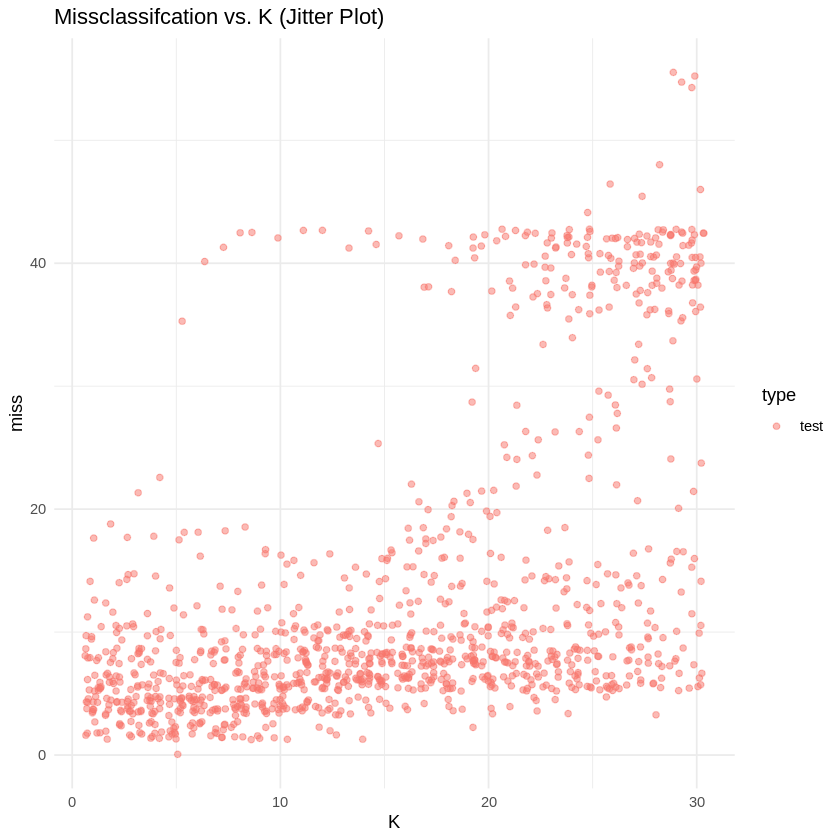

In [9]:
# plot misclassification percentage for train and test data sets
miss.m <- melt(miss, id=c('K', 'L')) # reshape for visualization
names(miss.m) <- c('K', 'L', 'type', 'miss')
ggplot(data=miss.m, aes(x=K, miss, color=type)) + 
    geom_jitter(alpha=0.5)  + 
    scale_fill_discrete(guide = guide_legend(title = NULL)) + 
    ggtitle('Missclassifcation vs. K (Jitter Plot)') + 
    theme_minimal() 

Now we produce the box plot of the error numbers (each of which corresponding to a sample set in our bootstrap sampling) we have obtained for our test set for each value of K. 

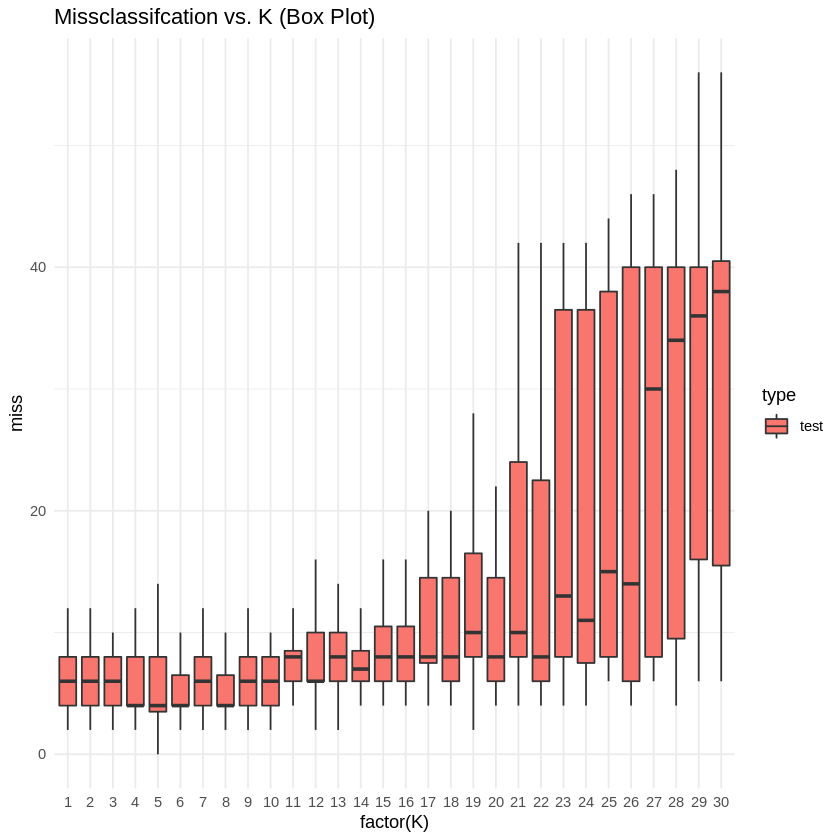

In [10]:
ggplot(data=miss.m[miss.m$type=='test',], aes(factor(K), miss,fill=type)) + 
    geom_boxplot(outlier.shape = NA)  + 
    scale_color_discrete(guide = guide_legend(title = NULL)) + 
    ggtitle('Missclassifcation vs. K (Box Plot)') + 
    theme_minimal()

# ignore the warnings (because of ignoring outliers)
options(warn=-1)

# Discussions
<ol>
    <li>As $K$ increases, how does the test error and its uncertainty behave (represented by the boxplots)? </li>
    <li>Rerun the above experiments for other values of `times` and `size`, then explain how increasing the number of samples and the size of each sample affect the error uncertainty.</li>
</ol>